In [1]:
import pandas as pd
import numpy as np
import math
import os
import pickle
from pniggli import niggli_reduce, niggli_check

rootdir = './material.pkl'

In [2]:
lattice_type_mapping={
    'triclinic': 0,
    'monoclinic': 1,
    'orthorhombic': 2,
    'tetragonal': 3,
    'rhombohedral': 4,
    'hexagonal': 5,
    'cubic': 6,
    'none': -1
}


def reduced_form(a, b, c, normalized=True):
    '''
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4844519/
    '''
    
    if normalized:
        b = b / np.linalg.norm(a)
        c = c / np.linalg.norm(a)
        a = a / np.linalg.norm(a)
    
    a2 = np.dot(a, a)
    b2 = np.dot(b, b)
    c2 = np.dot(c, c)
    
    bc = np.dot(b, c)
    ac = np.dot(a, c)
    ab = np.dot(a, b)
    
    return np.array([[a2, b2, c2], [bc, ac, ab]])


def get_lattice_vectors(a, b, c, alpha, beta, gamma):
    '''
    http://gisaxs.com/index.php/Unit_cell
    '''
    
    alpha = np.radians(alpha)
    beta = np.radians(beta)
    gamma = np.radians(gamma)
    
    # a 
    a1 = a
    a2 = 0
    a3 = 0
    
    # b
    b1 = b * np.cos(gamma)
    b2 = b * np.sin(gamma)
    b3 = 0
    
    # c
    c1 = c * np.cos(beta)
    c2 = c * (np.cos(alpha) - np.cos(beta)*np.cos(gamma)) / np.sin(gamma)
    c3 = c * np.sqrt(1 - np.cos(beta)**2 - ((np.cos(alpha) - np.cos(beta)*np.cos(gamma)) / np.sin(gamma))**2)

    a_ = np.array([a1, a2, a3])
    b_ = np.array([b1, b2, b3])
    c_ = np.array([c1, c2, c3])
    
    return a_, b_, c_


def get_symmetric_group(vec, eps=1e-6):
    a2 = vec[0,0]
    b2 = vec[0,1]
    c2 = vec[0,2]
    bc = vec[1,0]
    ac = vec[1,1]
    ab = vec[1,2]
#     if a2 <= b2 <= c2:
#         pass
#     elif a2 <= c2 <= b2:
#         b2, c2 = c2, b2
#         ac, ab = ab, ac
#     elif b2 <= a2 <= c2:
#         a2, b2 = b2, a2
#         bc, ac = ac, bc
#     elif b2 <= c2 <= a2:
#         a2, b2, c2 = b2, c2, a2
#         bc, ac, ab = ac, ab, bc
#     elif c2 <= a2 <= b2:
#         a2, b2, c2 = c2, a2, b2
#         bc, ac, ab = ab, bc, ac
#     elif c2 <= b2 <= a2:
#         a2, c2 = c2, a2
#         bc, ab = ab, bc

    # a=b=c
    if abs(a2-b2) < eps and abs(b2-c2) < eps and abs(a2-c2) < eps:
        #1
        if abs(a2- 2*bc) < eps and abs(b2- 2*ac) < eps and abs(c2- 2*ab) < eps:
            return lattice_type_mapping['cubic']
        #2
        if abs(ac- bc) < eps and abs(ab- ac) < eps and abs(bc- ab) < eps:
            return lattice_type_mapping['rhombohedral']
        #3
        if abs(bc) < eps and abs(ac) < eps and abs(ab) < eps:
            return lattice_type_mapping['cubic']
        #4
        if abs(bc + abs(bc)) < 0 and abs(ac + abs(bc)) < eps and abs(ab + abs(bc)) < eps: ###
            return lattice_type_mapping['rhombohedral']
        #5
        if abs(a2 + 3*bc) < eps and abs(b2 + 3*ac) < eps and abs(c2 + 3*ab) < eps:
            return lattice_type_mapping['cubic']
        #6
        if abs(2 * bc + a2 - abs(ab)) < eps and abs(2 * ac + a2 - abs(ab)) < eps and abs(ab + abs(ab)) < eps: ###
            return lattice_type_mapping['tetragonal']
        #7
        if abs(bc + abs(bc)) < eps and abs(2 * ac + a2 - abs(bc)) < eps and abs(2 * ab + a2 - abs(bc)) < eps: ###
            return lattice_type_mapping['tetragonal']
        #8
        if abs(bc + abs(bc)) < eps and abs(ac + abs(ac)) < eps and abs(ab + a2 - bc - ac) < eps:
            return lattice_type_mapping['orthorhombic']
    # a=b
    elif abs(a2-b2) < eps:
        #9
        if abs(a2- 2*bc) < eps and abs(a2- 2*ac) < eps and abs(a2- 2*ab) < eps:
            return lattice_type_mapping['rhombohedral']
        #10
        if abs(ac- bc) < eps:
            return lattice_type_mapping['monoclinic']
        #11
        if abs(bc) < eps and abs(ac) < eps and abs(ab) < eps:
            return lattice_type_mapping['tetragonal']
        #12
        if abs(bc) < eps and abs(ac) < eps and abs(a2 + 2 * ab) < eps:
            return lattice_type_mapping['hexagonal']    
        #13
        if abs(bc) < eps and abs(ac) < eps and abs(ab + abs(ab)) < eps:
            return lattice_type_mapping['orthorhombic']    
        #14
        if abs(bc + abs(bc)) < eps and abs(ac + abs(bc)) < eps and abs(ab + abs(ab)) < eps:
            return lattice_type_mapping['monoclinic']
        #15
        if abs(a2 + 2*bc) < eps and abs(b2 + 2*ac) < eps and abs(ab) < eps:
            return lattice_type_mapping['tetragonal']
        #16
        if abs(bc + abs(bc)) < eps and abs(ac + abs(bc)) < eps and abs(ab + a2 - 2 * abs(bc)) < eps:
            return lattice_type_mapping['orthorhombic']
        #17
        if abs(bc + abs(bc)) < eps and abs(ac + abs(ac)) < eps and abs(ab + a2 - abs(bc) - abs(ac)) < eps:
            return lattice_type_mapping['monoclinic']
    # b=c
    elif abs(b2-c2) < eps:
        #18
        if abs(a2- 4*bc) < eps and abs(a2- 2*ac) < eps and abs(a2- 2*ab) < eps:
            return lattice_type_mapping['tetragonal']
        #19
        if abs(a2- 2*ac) < eps and abs(a2- 2*ab) < eps:
            return lattice_type_mapping['orthorhombic']
        #20
        if abs(ab - ac) < eps:
            return lattice_type_mapping['monoclinic']
        #21
        if abs(bc) < eps and abs(ac) < eps and abs(ab) < eps:
            return lattice_type_mapping['tetragonal']   
        #22
        if abs(b2 + 2*bc) < eps and abs(ac) < eps and abs(ab) < eps:
            return lattice_type_mapping['hexagonal']    
        #23
        if abs(bc + abs(bc)) < eps and abs(ac) < eps and abs(ab) < eps:
            return lattice_type_mapping['orthorhombic']
        #24
        if abs(- a2 + 3* b2 + 6*bc) < eps and abs(a2 + 3*ac) < eps and abs(a2 + 3*ab) < eps:
            return lattice_type_mapping['rhombohedral']
        #25
        if abs(bc + abs(bc)) < eps and abs(ac + abs(ac)) < eps and abs(ab + abs(ac)) < eps:
            return lattice_type_mapping['monoclinic']
    else:
        #26
        if abs(a2- 4*bc) < eps and abs(a2- 2*ac) < eps and abs(a2- 2*ab) < eps:
            return lattice_type_mapping['tetragonal']
        #27
        if abs(a2- 2*ac) < eps and abs(a2- 2*ab) < eps:
            return lattice_type_mapping['monoclinic']
        #28
        if abs(ab- 2*bc) < eps and abs(a2- 2*ac) < eps:
            return lattice_type_mapping['monoclinic']
        #29
        if abs(ac- 2*bc) < eps and abs(a2- 2*ab) < eps:
            return lattice_type_mapping['monoclinic']
        #30
        if abs(b2- 2*bc) < eps and abs(ab- 2*ac) < eps:
            return lattice_type_mapping['monoclinic']
        #32
        if abs(bc) < eps and abs(ac) < eps and abs(ab) < eps:
            return lattice_type_mapping['orthorhombic']
        #33
        if abs(bc) < eps and abs(ac + abs(ac)) < eps and abs(ab) < eps:
            return lattice_type_mapping['monoclinic']
        #34
        if abs(bc) < eps and abs(ac) < eps and abs(ab + abs(ab)) < eps:
            return lattice_type_mapping['monoclinic']
        #35
        if abs(bc + abs(bc)) < eps and abs(ac) < eps and abs(ab) < eps:
            return lattice_type_mapping['monoclinic']
        #36
        if abs(bc) < eps and abs(a2 + 2*ac) < eps and abs(ab) < eps:
            return lattice_type_mapping['orthorhombic']
        #37
        if abs(bc + abs(bc)) < eps and abs(a2 + 2*ac) < eps and abs(ab) < eps:
            return lattice_type_mapping['monoclinic']
        #38
        if abs(bc) < eps and abs(ac) < eps and abs(a2 + 2*ab) < eps:
            return lattice_type_mapping['orthorhombic']
        #39
        if abs(bc + abs(bc)) < eps and abs(ac) < eps and abs(a2 + 2*ab) < eps:
            return lattice_type_mapping['monoclinic']
        #40
        if abs(b2+ 2*bc) < eps and abs(ac) < eps and abs(ab) < eps:
            return lattice_type_mapping['orthorhombic']
        #41
        if abs(b2+ 2*bc) < eps and abs(ac + abs(ac)) < eps and abs(ab) < eps:
            return lattice_type_mapping['monoclinic']
        #42
        if abs(b2+ 2*bc) < eps and abs(a2+ 2*ac) < eps and abs(ab) < eps:
            return lattice_type_mapping['orthorhombic']
        #43
        if abs(b2+ 2*bc - abs(ab)) < eps and abs(a2+ 2*ac -abs(ab)) < eps and abs(ab + abs(ab)) < eps:
            return lattice_type_mapping['monoclinic']
        #44
        if abs(bc + abs(bc)) < eps and abs(ac + abs(ac)) < eps and abs(ab + abs(ab)) < eps:
            return lattice_type_mapping['triclinic']
        #31 
        return lattice_type_mapping['triclinic']

    return lattice_type_mapping['none']

In [3]:
id = []
params = np.empty([41100,6])

with open(rootdir, 'rb') as f:
    material = pickle.load(f)
    for i, k in enumerate(material.keys()):
        id.append(k)
        params[i] = np.array(material[k]['param'])

In [4]:
abc = np.empty([41100,3,3])

for i, param in enumerate(params):
    a, b, c = get_lattice_vectors(
        param[0], 
        param[1],
        param[2],
        param[3],
        param[4],
        param[5])
    
    abc[i][0] = a
    abc[i][1] = b
    abc[i][2] = c

In [9]:
niggli = np.empty([41100,3,3])

for i, vec in enumerate(abc):
    niggli[i,:,:] = niggli_reduce(vec, eps=1e-12)

In [10]:
rf = np.empty([41100,2,3])

for i, vec in enumerate(niggli):
    rf[i,:,:] = reduced_form(vec[0,:], vec[1,:], vec[2,:])

In [11]:
count = 0
atom_types = []
err_count = []
for eps in [1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12]:
    count = 0
    for i in range(rf.shape[0]):
        atom_type = get_symmetric_group(rf[i],eps=eps)
        atom_types.append(atom_type)
        if atom_type==-1:
            count = count +1 
            #print("Line {}, ID: {}, lattice parameter: {}, type: {}".format(i, id[i], rf[i,:], atom_type))
    print(count)
    err_count.append(count)

496
413
384
236
355
225
515
302
70
45


In [15]:
count = 0
atom_types = []
count = 0
eps = 1e-6
for i in range(rf.shape[0]):
    atom_type = get_symmetric_group(rf[i],eps=eps)
    atom_types.append(atom_type)
    if atom_type==-1:
        count = count +1 
        print("Line {}, ID: {}, lattice parameter: {}, type: {}".format(i, id[i], rf[i,:], atom_type))
print(count)

Line 30, ID: mp-10126, lattice parameter: [[ 1.00000000e+00  1.00000093e+00  1.36752062e+00]
 [-5.00000463e-01 -4.99984781e-01 -2.82016036e-10]], type: -1
Line 126, ID: mp-1029179, lattice parameter: [[1.00000000e+00 1.00000012e+00 1.28490030e+02]
 [8.42322620e-05 8.60507292e-05 4.99992526e-01]], type: -1
Line 830, ID: mp-547017, lattice parameter: [[ 1.          1.25244844  1.25244912]
 [-0.24420934 -0.1734791  -0.17347783]], type: -1
Line 1132, ID: mp-622576, lattice parameter: [[ 1.00000000e+00  1.00000016e+00  9.67863608e+00]
 [-2.05750643e-06 -8.18429493e-06 -4.85587575e-06]], type: -1
Line 1263, ID: mp-677010, lattice parameter: [[ 1.          1.00000019  1.00000021]
 [ 0.50602208 -0.49117134  0.00280674]], type: -1
Line 1298, ID: mp-690560, lattice parameter: [[ 1.          1.00000022  1.00000012]
 [-0.02370051 -0.48058178 -0.4957178 ]], type: -1
Line 1563, ID: mp-768291, lattice parameter: [[1.00000000e+00 1.00000084e+00 3.96479262e+00]
 [2.12509833e-06 2.77545350e-07 2.2536587

(array([  496.,  3808., 21244.,  5530.,  1047.,  4848.,     0.,  4127.]),
 array([-1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5]),
 <BarContainer object of 8 artists>)

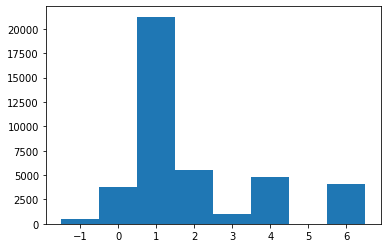

In [16]:
import matplotlib.pyplot as plt

bins = np.arange(-1, max(atom_types) + 1.5) - 0.5
plt.hist(atom_types, bins)